# Predicting House Prices on [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

In [75]:
!pip install mxnet
!pip install d2l
# If pandas is not installed, please uncomment the following line:
!pip install pandas

In [0]:
%matplotlib inline
import d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn, utils
import numpy as np
import pandas as pd

## Accessing and Reading Data Sets

In [77]:
utils.download('https://github.com/d2l-ai/d2l-en/raw/master/data/kaggle_house_pred_train.csv')
utils.download('https://github.com/d2l-ai/d2l-en/raw/master/data/kaggle_house_pred_test.csv')
train_data = pd.read_csv('kaggle_house_pred_train.csv')
test_data = pd.read_csv('kaggle_house_pred_test.csv')
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


## A Quick View of the Data

In [78]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


## Combile Train and Test for Pre-processing

In [0]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

## Standardize and Replace Missing Value with 0

In [0]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
all_features = all_features.fillna(0)

## Replace Discrete Feature with One-hot Encoding 

In [81]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 354)

## Preprocessed Dataset

In [0]:
n_train = train_data.shape[0]
train_features = nd.array(all_features[:n_train].values)
test_features = nd.array(all_features[n_train:].values)
train_labels = nd.array(train_data.SalePrice.values).reshape((-1, 1))

## Linear Regression with L2 Loss

In [0]:
loss = gloss.L2Loss()

def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    return net

## Log Root Mean Square Error 

$$L = \sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}$$

A small value $\delta$ of $\log y - \log \hat{y}$ translates into $e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$. 


In [0]:
def log_rmse(net, features, labels):
    clipped_preds = nd.clip(net(features), 1, float('inf'))
    rmse = nd.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.asscalar()

## Optimization

In [0]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'adam', {
        'learning_rate': learning_rate, 'wd': weight_decay})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## Get k-Fold Cross-Validation Data

In [0]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
    return X_train, y_train, X_valid, y_valid

##  k-Fold Cross-Validation

In [0]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs+1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse',
                     legend=['train', 'valid'], yscale='log')
        print('fold %d, train rmse: %f, valid rmse: %f' % (
            i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

## Model Selection


fold 0, train rmse: 0.169813, valid rmse: 0.157036
fold 1, train rmse: 0.162226, valid rmse: 0.189630
fold 2, train rmse: 0.163775, valid rmse: 0.168133
fold 3, train rmse: 0.167277, valid rmse: 0.154363
fold 4, train rmse: 0.163105, valid rmse: 0.183126
5-fold validation: avg train rmse: 0.165239, avg valid rmse: 0.170458


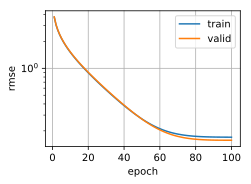

In [88]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f'
      % (k, train_l, valid_l))


##  Predict and Submit

In [0]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(range(1, num_epochs+1), train_ls, xlabel='epoch', ylabel='rmse',
            yscale='log')
    print('train rmse %f' % train_ls[-1])
    # Apply the network to the test set
    preds = net(test_features).asnumpy()
    # Reformat it for export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)


train rmse 0.162697


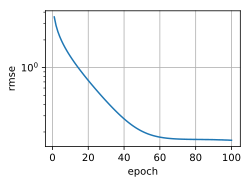

In [90]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

#Keras

In [0]:
train_features = np.array(all_features[:n_train].values)
test_features = np.array(all_features[n_train:].values)
train_labels = np.array(train_data.SalePrice.values).reshape((-1, 1))


In [0]:
from keras.models import Sequential
from keras.layers import Dense
import keras.regularizers as regularizers
import keras.optimizers as optimizers
import keras.initializers as initializers
import tensorflow as tf
from matplotlib import pyplot as plt

def get_keras_net(learning_rate, weight_decay):
    model = Sequential()
    model.add(Dense(1, kernel_initializer=initializers.RandomNormal(stddev=1),
                    kernel_regularizer=regularizers.l2(weight_decay), input_shape=(train_features.shape[1],)))
    sgd = optimizers.SGD(lr=learning_rate, momentum=0.9)
    model.compile(optimizer=sgd, loss='mean_squared_logarithmic_error',metrics=['mse'])
    return model

In [0]:
from keras.models import Model
from keras.layers import Dense, Input, Dropout
from keras.optimizers import Adam

def create_model(dim_layer1, dim_layer2, learning_rate, dropout) -> Model:
    input_layer = Input(shape=(11,))
    
    first_hidden = Dense(dim_layer1, kernel_initializer='uniform', activation='relu')(input_layer)
    
    dropout = Dropout(dropout)(first_hidden)
    
    second_hidden = Dense(dim_layer2, kernel_initializer='uniform', activation='relu')(dropout)
    
    output = Dense(1, kernel_initializer='uniform', activation='sigmoid')(second_hidden)
    
    model = Model(inputs=input_layer, outputs=output)
    
    adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999)
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mse'])
    
    model.summary()
    return model

In [0]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = np.concatenate([X_train, X_part], axis=0)
            y_train = np.concatenate([y_train, y_part], axis=0)
    return X_train, y_train, X_valid, y_valid


def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_keras_net(learning_rate, weight_decay)
        history = net.fit(data[0], data[1], epochs=num_epochs, batch_size=batch_size, verbose=2,
                          validation_data=(data[2], data[3]))
        if i != 0:
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'test'], loc='upper left')
            plt.show()
    return train_l_sum / k, valid_l_sum / k

Train on 1168 samples, validate on 292 samples
Epoch 1/100
 - 2s - loss: 29.2885 - mean_squared_error: 38608810488.9863 - val_loss: 17.9352 - val_mean_squared_error: 37639463304.7671
Epoch 2/100
 - 0s - loss: 17.0537 - mean_squared_error: 38152065416.7671 - val_loss: 16.6364 - val_mean_squared_error: 37485245369.8630
Epoch 3/100
 - 0s - loss: 16.3608 - mean_squared_error: 38065960707.5069 - val_loss: 16.3007 - val_mean_squared_error: 37440716856.1096
Epoch 4/100
 - 0s - loss: 16.1030 - mean_squared_error: 38031219108.8219 - val_loss: 16.0933 - val_mean_squared_error: 37412275298.1918
Epoch 5/100
 - 0s - loss: 15.9107 - mean_squared_error: 38004599990.3562 - val_loss: 15.9117 - val_mean_squared_error: 37386566782.2466
Epoch 6/100
 - 0s - loss: 15.7355 - mean_squared_error: 37979642024.3288 - val_loss: 15.7423 - val_mean_squared_error: 37361974005.4795
Epoch 7/100
 - 0s - loss: 15.5709 - mean_squared_error: 37955626474.9589 - val_loss: 15.5816 - val_mean_squared_error: 37338012181.0411
E

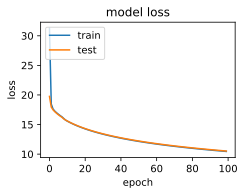

Train on 1168 samples, validate on 292 samples
Epoch 1/100
 - 2s - loss: 24.9589 - mean_squared_error: 37621221572.3836 - val_loss: 15.2659 - val_mean_squared_error: 40341451228.9315
Epoch 2/100
 - 0s - loss: 14.4702 - mean_squared_error: 37004792088.5479 - val_loss: 14.1910 - val_mean_squared_error: 40147017307.1781
Epoch 3/100
 - 0s - loss: 13.9390 - mean_squared_error: 36905876886.7945 - val_loss: 13.9784 - val_mean_squared_error: 40104729473.7534
Epoch 4/100
 - 0s - loss: 13.7926 - mean_squared_error: 36877173998.4658 - val_loss: 13.8738 - val_mean_squared_error: 40083616333.1507
Epoch 5/100
 - 0s - loss: 13.6978 - mean_squared_error: 36858292588.7123 - val_loss: 13.7857 - val_mean_squared_error: 40065610766.0274
Epoch 6/100
 - 0s - loss: 13.6122 - mean_squared_error: 36840998940.0548 - val_loss: 13.7021 - val_mean_squared_error: 40048287575.6712
Epoch 7/100
 - 0s - loss: 13.5298 - mean_squared_error: 36824196362.5205 - val_loss: 13.6210 - val_mean_squared_error: 40031229727.5616
E

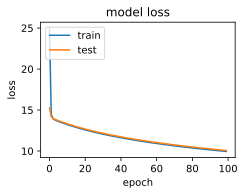

Train on 1168 samples, validate on 292 samples
Epoch 1/100
 - 2s - loss: 32.0402 - mean_squared_error: 39618613809.0959 - val_loss: 19.1899 - val_mean_squared_error: 34328354226.8493
Epoch 2/100
 - 0s - loss: 18.8202 - mean_squared_error: 39244979831.2329 - val_loss: 17.6935 - val_mean_squared_error: 34195718003.7260
Epoch 3/100
 - 0s - loss: 17.9467 - mean_squared_error: 39160055050.5205 - val_loss: 17.2310 - val_mean_squared_error: 34148030688.4384
Epoch 4/100
 - 0s - loss: 17.5611 - mean_squared_error: 39118066000.6575 - val_loss: 16.9243 - val_mean_squared_error: 34114404688.6575
Epoch 5/100
 - 0s - loss: 17.2662 - mean_squared_error: 39084055622.1370 - val_loss: 16.6586 - val_mean_squared_error: 34083919731.7260
Epoch 6/100
 - 0s - loss: 17.0043 - mean_squared_error: 39052350786.6301 - val_loss: 16.4150 - val_mean_squared_error: 34054847333.6986
Epoch 7/100
 - 0s - loss: 16.7616 - mean_squared_error: 39022015866.7397 - val_loss: 16.1898 - val_mean_squared_error: 34027009739.3973
E

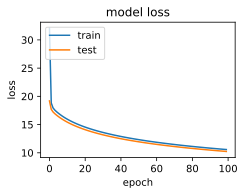

Train on 1168 samples, validate on 292 samples
Epoch 1/100
 - 1s - loss: 25.0394 - mean_squared_error: 37971118276.3836 - val_loss: 14.4266 - val_mean_squared_error: 38528617962.9589
Epoch 2/100
 - 0s - loss: 13.7136 - mean_squared_error: 37316798520.1096 - val_loss: 13.4037 - val_mean_squared_error: 38325477852.9315
Epoch 3/100
 - 0s - loss: 13.2171 - mean_squared_error: 37213133501.3699 - val_loss: 13.2159 - val_mean_squared_error: 38284104465.5342
Epoch 4/100
 - 0s - loss: 13.0933 - mean_squared_error: 37185679303.8904 - val_loss: 13.1313 - val_mean_squared_error: 38264948371.2877
Epoch 5/100
 - 0s - loss: 13.0181 - mean_squared_error: 37168520542.6849 - val_loss: 13.0622 - val_mean_squared_error: 38249100554.5205
Epoch 6/100
 - 0s - loss: 12.9511 - mean_squared_error: 37153091527.8904 - val_loss: 12.9963 - val_mean_squared_error: 38233813609.2055
Epoch 7/100
 - 0s - loss: 12.8861 - mean_squared_error: 37137904317.3699 - val_loss: 12.9323 - val_mean_squared_error: 38218772648.3288
E

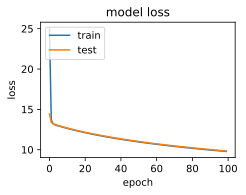


5-fold validation: avg train rmse: 0.000000, avg valid rmse: 0.000000


In [95]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print('\n%d-fold validation: avg train rmse: %f, avg valid rmse: %f'
      % (k, train_l, valid_l))

## Tuning Ideas


1. What happens if you try to predict the log price rather than the price?
1. Is it always a good idea to replace missing values by their mean?
1. What happens if you add an indicator variable for missing values.?
1. Tune the hyperparameters through k-fold crossvalidation.
1. Change he model (layers, regularization, dropout).